In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from utils.gtsrb_dataset import GTSRBDataset
from models.tsr_cnn import TSRNet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# ------------------------------
# Dataset setup
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = GTSRBDataset(csv_file="./data/Train.csv", root_dir="./data/", transform=transform)
test_dataset  = GTSRBDataset(csv_file="./data/Test.csv",  root_dir="./data/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ------------------------------
# Model, Loss, Optimizer
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TSRNet(num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ------------------------------
# Checkpoint setup
# ------------------------------
ckpt_dir = "./results/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_acc = 0.0

# ------------------------------
# Training loop
# ------------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # --------------------------
    # Evaluation after each epoch
    # --------------------------
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} | Test Acc: {acc:.2f}%")

    # --------------------------
    # Save best checkpoint
    # --------------------------
    if acc > best_acc:
        best_acc = acc
        ckpt_path = os.path.join(ckpt_dir, f"tsr_best_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': best_acc,
        }, ckpt_path)
        print(f"✅ Saved best model checkpoint with accuracy {best_acc:.2f}%")

print(f"Training completed. Best accuracy: {best_acc:.2f}%")


Epoch [1/10] - Loss: 0.5868 | Test Acc: 88.41%
✅ Saved best model checkpoint with accuracy 88.41%
Epoch [2/10] - Loss: 0.0727 | Test Acc: 91.85%
✅ Saved best model checkpoint with accuracy 91.85%
Epoch [3/10] - Loss: 0.0365 | Test Acc: 93.18%
✅ Saved best model checkpoint with accuracy 93.18%
Epoch [4/10] - Loss: 0.0216 | Test Acc: 92.15%
Epoch [5/10] - Loss: 0.0213 | Test Acc: 93.19%
✅ Saved best model checkpoint with accuracy 93.19%
Epoch [6/10] - Loss: 0.0221 | Test Acc: 93.88%
✅ Saved best model checkpoint with accuracy 93.88%
Epoch [7/10] - Loss: 0.0153 | Test Acc: 93.90%
✅ Saved best model checkpoint with accuracy 93.90%
Epoch [8/10] - Loss: 0.0121 | Test Acc: 92.65%
Epoch [9/10] - Loss: 0.0175 | Test Acc: 93.63%
Epoch [10/10] - Loss: 0.0090 | Test Acc: 93.98%
✅ Saved best model checkpoint with accuracy 93.98%
Training completed. Best accuracy: 93.98%


Device: cuda
Loaded checkpoint: epoch 10, acc 93.98258115597783
Clean Test Accuracy: 93.98%

FGSM Results (eps=0.03):
  Clean Accuracy: 93.98%
  Adversarial Accuracy: 52.64%
  Attack Success Rate (ASR): 43.99%


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

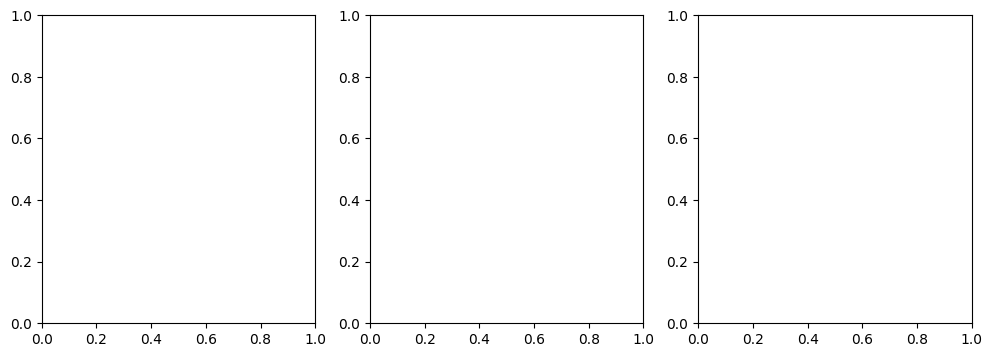

In [ ]:
# ==================================================
# FGSM / PGD Attack Evaluation with ASR
# ==================================================
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from utils.attacks import fgsm_attack, pgd_attack
from utils.visualization import save_sample
from models.tsr_cnn import TSRNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Load trained TSR model
# -----------------------------
ckpt_path = "./results/checkpoints/tsr_best_model.pth"
model = TSRNet(num_classes=43).to(device)
optimizer = torch.optim.Adam(model.parameters())

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    try:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    except Exception:
        pass
    print(f"Loaded checkpoint: epoch {ckpt.get('epoch', '?')}, acc {ckpt.get('accuracy', '?')}")
else:
    raise FileNotFoundError("Checkpoint not found at " + ckpt_path)

model.eval()

# -----------------------------
# Helper: Evaluation Function
# -----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# -----------------------------
# Evaluate on Clean Data
# -----------------------------
clean_acc, clean_preds, clean_labels = evaluate(model, test_loader, device)
print(f"Clean Test Accuracy: {clean_acc:.2f}%")

# -----------------------------
# FGSM Attack
# -----------------------------
eps = 0.03  # attack strength
model.eval()
adv_correct, adv_total = 0, 0
correct_to_wrong = 0
original_correct = 0

for imgs, labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)
    # Count correctly classified samples
    correct_mask = (preds == labels)
    original_correct += correct_mask.sum().item()
    
    # Generate adversarial examples
    adv_imgs = fgsm_attack(model, imgs, labels, eps=eps, device=device)
    
    with torch.no_grad():
        adv_outputs = model(adv_imgs)
        _, adv_preds = torch.max(adv_outputs, 1)
    
    adv_correct += (adv_preds == labels).sum().item()
    adv_total += labels.size(0)
    
    # Count those flipped from correct → wrong
    correct_to_wrong += ((preds == labels) & (adv_preds != labels)).sum().item()

adv_acc = 100.0 * adv_correct / adv_total
attack_success_rate = 100.0 * correct_to_wrong / max(original_correct, 1)

print(f"\nFGSM Results (eps={eps}):")
print(f"  Clean Accuracy: {clean_acc:.2f}%")
print(f"  Adversarial Accuracy: {adv_acc:.2f}%")
print(f"  Attack Success Rate (ASR): {attack_success_rate:.2f}%")

# -----------------------------
# Visualization (Fixed for CUDA)
# -----------------------------
imgs_batch, labels_batch = next(iter(test_loader))
imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)
adv_imgs_batch = fgsm_attack(model, imgs_batch, labels_batch, eps=eps, device=device)

def denorm(x):
    return torch.clamp(x * 0.5 + 0.5, 0, 1)  # inverse of normalization

orig = denorm(imgs_batch[:8])
adv = denorm(adv_imgs_batch[:8])
pert = (adv - orig).abs() * 10.0  # amplify perturbation

grid_orig = make_grid(orig.cpu(), nrow=4)
grid_adv = make_grid(adv.cpu(), nrow=4)
grid_pert = make_grid(pert.cpu(), nrow=4)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.transpose(grid_orig.numpy(), (1,2,0)))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(np.transpose(grid_adv.numpy(), (1,2,0)))
axes[1].set_title(f"Adversarial (ε={eps})")
axes[1].axis("off")

axes[2].imshow(np.transpose(grid_pert.numpy(), (1,2,0)))
axes[2].set_title("Perturbation ×10")
axes[2].axis("off")

plt.tight_layout()
plt.show()


os.makedirs("results/sample_outputs", exist_ok=True)
save_sample(orig, "results/sample_outputs/original_grid.png")
save_sample(adv, "results/sample_outputs/adversarial_grid.png")
save_sample(pert, "results/sample_outputs/perturbation_grid.png")

# -----------------------------
# Optional PGD Attack
# -----------------------------
run_pgd = False  # toggle True to test PGD
if run_pgd:
    eps, alpha, iters = 0.03, 0.007, 10
    print(f"\nRunning PGD (eps={eps}, alpha={alpha}, iters={iters})...")
    pgd_correct, pgd_total, correct_to_wrong = 0, 0, 0
    original_correct = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct_mask = (preds == labels)
        original_correct += correct_mask.sum().item()
        
        adv_imgs = pgd_attack(model, imgs, labels, eps=eps, alpha=alpha, iters=iters, device=device)
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = torch.max(adv_outputs, 1)
        pgd_correct += (adv_preds == labels).sum().item()
        pgd_total += labels.size(0)
        correct_to_wrong += ((preds == labels) & (adv_preds != labels)).sum().item()
    
    pgd_acc = 100.0 * pgd_correct / pgd_total
    pgd_asr = 100.0 * correct_to_wrong / max(original_correct, 1)
    print(f"PGD Accuracy: {pgd_acc:.2f}%  |  Attack Success Rate: {pgd_asr:.2f}%")
